In [5]:
# Core libraries
import pandas as pd
import numpy as np

# NLP libraries
import nltk
import re
import string

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Load datasets
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

# Add labels
fake["label"] = 0   # Fake news
true["label"] = 1   # Real news

# Combine datasets
df = pd.concat([fake, true], axis=0)

# Shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)

# Inspect dataset
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,Trump’s Legal Team In Uproar After He Forces ...,Donald Trump s inner circle is shattering as w...,News,"July 21, 2017",0
2,“LIE” WITNESS NEWS: JIMMY KIMMEL SHOW Asks Peo...,It s hard to imagine so many people would lie ...,left-news,"Sep 27, 2016",0
3,WATCH: Anderson Cooper BEATS DOWN Trump Campa...,Kellyanne Conway finally got buried by a barra...,News,"November 7, 2016",0
4,Trump's team blocks U.S. House appearance by P...,WASHINGTON (Reuters) - U.S. President-elect Do...,politicsNews,"January 11, 2017",1


In [24]:
# Dataset shape
print("Dataset shape:")
df.shape

Dataset shape:


(44898, 5)

In [25]:
# Check missing values
print("Missing values:")
df.isnull().sum()

Missing values:


,0
title,0
text,0
subject,0
date,0
label,0


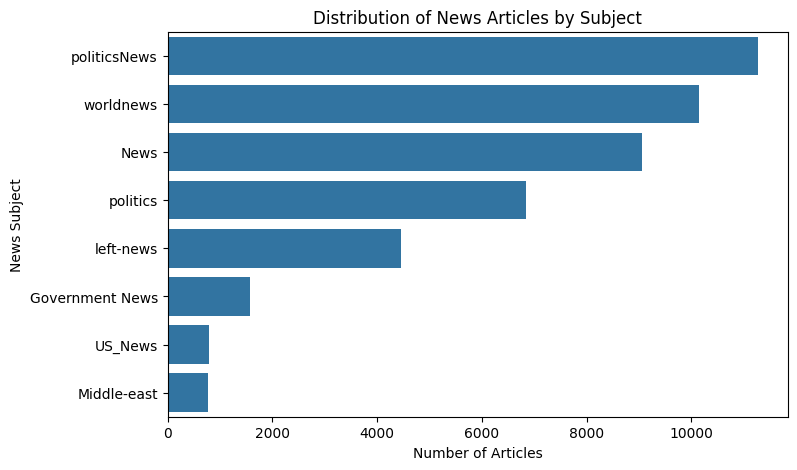

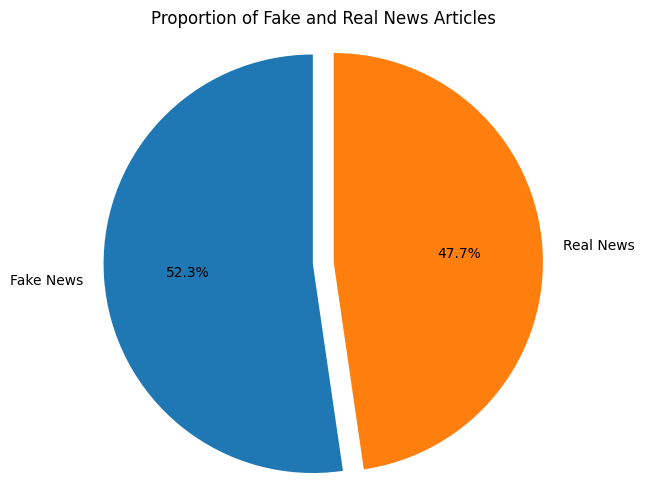

In [30]:
# Data visualisations

# Subject-wise count
subject_counts = df['subject'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(
    x=subject_counts.values,
    y=subject_counts.index
)
plt.title('Distribution of News Articles by Subject')
plt.xlabel('Number of Articles')
plt.ylabel('News Subject')
plt.show()

# Count of each class
class_counts = df['label'].value_counts()

# Labels
labels = ['Fake News', 'Real News']

plt.figure(figsize=(6,6))
plt.pie(
    class_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0.05)
)
plt.title('Proportion of Fake and Real News Articles')
plt.axis('equal')
plt.show()

In [6]:
# Text Cleaning & Preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokenisation
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and lemmatise
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(tokens)

# Apply preprocessing on article text
df["clean_text"] = df["text"].apply(preprocess_text)

df[["text", "clean_text"]].head()

,text,clean_text
0,If there s one person that Donald Trump can t ...,one person donald trump stand criticizing pred...
1,"BONN, Germany (Reuters) - China has a chance t...",bonn germany reuters china chance assert leade...
2,The Democrat s war on mostly ugly women Forme...,democrat war mostly ugly woman former pennsylv...
3,"If Republicans listen to this sage advice, Don...",republican listen sage advice donald trump wou...
4,"On Tuesday night, Fox News blowhard and right-...",tuesday night fox news blowhard rightwing mess...


In [7]:
# Train–Test Split
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Feature Extraction using TF-IDF
tfidf = TfidfVectorizer(
    max_df=0.7,
    min_df=5,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape

(35918, 268697)

In [9]:
# Rule-Based Fake News Classifier
fake_keywords = [
    "breaking", "shocking", "you wont believe", "exposed",
    "truth revealed", "hoax", "conspiracy"
]

def rule_based_classifier(text):
    score = 0
    for word in fake_keywords:
        if word in text:
            score += 1
    return 0 if score > 0 else 1   # 0 = Fake, 1 = Real

# Apply rule-based predictions
rule_preds = X_test.apply(rule_based_classifier)

# Evaluate
print("Rule-Based Accuracy:", accuracy_score(y_test, rule_preds))
print(classification_report(y_test, rule_preds))

Rule-Based Accuracy: 0.5220489977728285
              precision    recall  f1-score   support

           0       0.78      0.12      0.21      4696
           1       0.50      0.96      0.66      4284

    accuracy                           0.52      8980
   macro avg       0.64      0.54      0.43      8980
weighted avg       0.64      0.52      0.42      8980



In [10]:
# Machine Learning Models

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

nb_preds = nb.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

lr_preds = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

# Support Vector Machine (SVM)
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

svm_preds = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

Naive Bayes Accuracy: 0.9597995545657015
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4696
           1       0.96      0.95      0.96      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980

Logistic Regression Accuracy: 0.9851893095768374
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.98      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

SVM Accuracy: 0.9968819599109131
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   ma

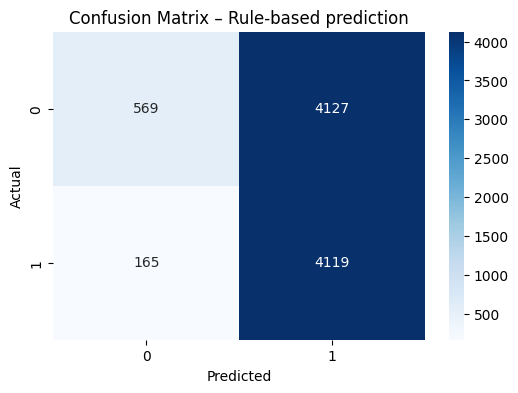

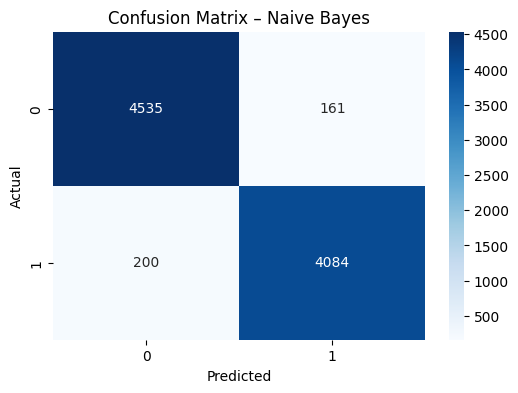

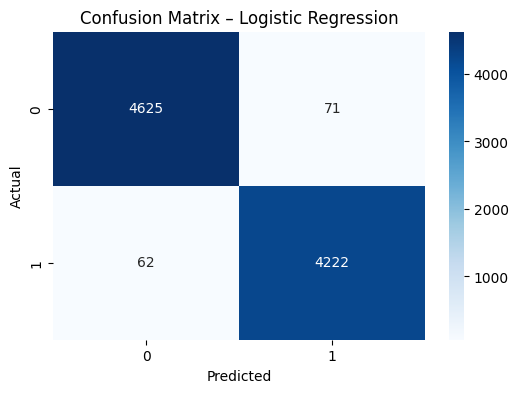

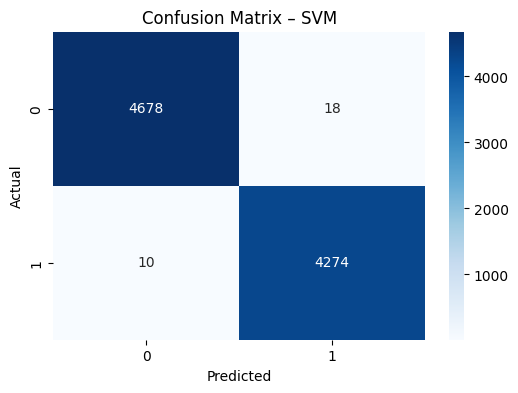

In [20]:
# Confusion Matrix Visualisation

# Rule-based prediction
cm = confusion_matrix(y_test, rule_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Rule-based prediction")
plt.show()

# Naive Bayes
cm = confusion_matrix(y_test, nb_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Naive Bayes")
plt.show()

# Logistic Regression
cm = confusion_matrix(y_test, lr_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

# Support Vector Machine (SVM)
cm = confusion_matrix(y_test, svm_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – SVM")
plt.show()

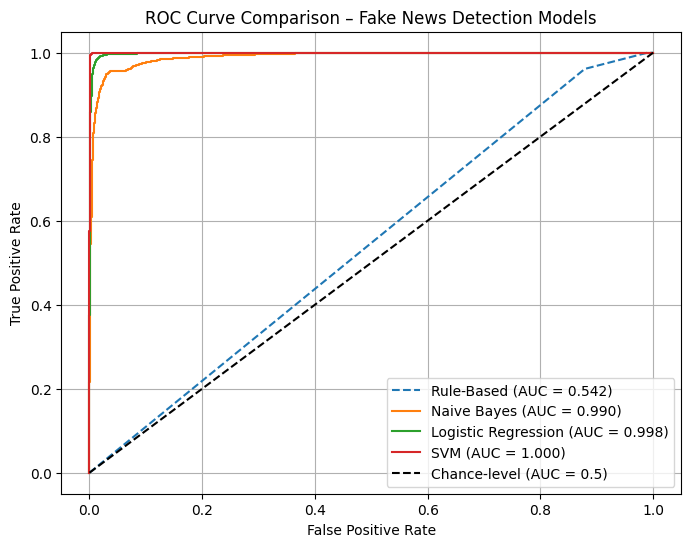

In [18]:
# Generate scores for all models

def rule_based_score(text):
    score = 0
    for word in fake_keywords:
        if word in text:
            score += 1
    return score

# Apply rule-based scores
rule_scores = X_test.apply(rule_based_score)

# Normalise scores between 0 and 1
rule_scores_norm = rule_scores / rule_scores.max()

# Naive Bayes - probabilities
nb_probs = nb.predict_proba(X_test_tfidf)[:, 1]

# Logistic Regression - probabilities
lr_probs = lr.predict_proba(X_test_tfidf)[:, 1]

# SVM – Decision Function
svm_scores = svm.decision_function(X_test_tfidf)

# Compute ROC Curves & AUC Scores
from sklearn.metrics import roc_curve, roc_auc_score

# Rule-based ROC (invert since higher score = fake)
fpr_rule, tpr_rule, _ = roc_curve(y_test, 1 - rule_scores_norm)
auc_rule = roc_auc_score(y_test, 1 - rule_scores_norm)

# Naive Bayes ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)
auc_nb = roc_auc_score(y_test, nb_probs)

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
auc_lr = roc_auc_score(y_test, lr_probs)

# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
auc_svm = roc_auc_score(y_test, svm_scores)

# Plot Combined ROC Curve (ALL MODELS)
plt.figure(figsize=(8,6))

plt.plot(fpr_rule, tpr_rule, linestyle='--', label=f'Rule-Based (AUC = {auc_rule:.3f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.3f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})')

plt.plot([0,1], [0,1], 'k--', label='Chance-level (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison – Fake News Detection Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()